In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Multiply, Add, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Define a custom R2 score metric for TensorFlow
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [3]:
def train_and_evaluate_gru_model(target_variable, flag_train=True, _epochs=100, _batch_size=10):
    # Load your data from the Excel file
    mgh_data = pd.read_excel("gru-datasets.xlsx")

    # Select relevant features: time steps, predicted GL, and predicted NN values
    features = ['timesteps', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

    # Standardize each feature independently
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for GRU input (samples, timesteps, features)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Adjusting q_physics and q_nn input shapes
    q_physics_train = X_train_scaled[:, :, 1]  # Extracting the (Predicted GL) as q_physics
    q_nn_train = X_train_scaled[:, :, 2]       # Extracting the (Predicted NN) as q_nn

    q_physics_test = X_test_scaled[:, :, 1]
    q_nn_test = X_test_scaled[:, :, 2]
    
    if flag_train:
        # Building the GRU model
        input_layer = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))

        # GRU layer
        gru_output = GRU(64, return_sequences=False)(input_layer)

        # Dense layers to predict w_physics and w_nn
        w_physics = Dense(1, activation='sigmoid')(gru_output)
        w_nn = Lambda(lambda x: 1.0 - x)(w_physics)  # w_nn = 1 - w_physics

        # Input layers for q_physics and q_nn
        q_physics = Input(shape=(1,))
        q_nn = Input(shape=(1,))

        # Computing y_hat
        y_hat_physics = Multiply()([q_physics, w_physics])
        y_hat_nn = Multiply()([q_nn, w_nn])
        y_hat = Add()([y_hat_physics, y_hat_nn])

        # Defining the model
        model = Model(inputs=[input_layer, q_physics, q_nn], outputs=y_hat)

        # Compile the model
        # model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', r2_score_metric])
        model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Training the model
        history = model.fit([X_train_scaled, q_physics_train, q_nn_train], y_train,
                            validation_split=0.2, epochs=_epochs, batch_size=_batch_size, verbose=1)

        # Save the model and scaler
        model.save(f'gru-models/{target_variable}_gru_model.keras')
        joblib.dump(scaler, f'gru-models/{target_variable}_gru_scaler.pkl')

        # Predict using the trained model
        y_hat_test = model.predict([X_test_scaled, q_physics_test, q_nn_test])
        
    else:
        # Load the model and scaler
        model = load_model(f'gru-models/{target_variable}_gru_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        scaler = joblib.load(f'gru-models/{target_variable}_gru_scaler.pkl')

        # Predict using the loaded model
        y_hat_test = model.predict([X_test_scaled, q_physics_test, q_nn_test])

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    # Plotting and reporting (no changes here)
    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


In [6]:
train_and_evaluate_gru_model('PAR In', flag_train=False)

ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().


Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3055.5354 - mae: 55.1906 - r2_score_metric: -844.6937 - val_loss: 3012.2134 - val_mae: 54.7810 - val_r2_score_metric: -726.2441
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3037.7251 - mae: 55.0269 - r2_score_metric: -1124.3884 - val_loss: 3004.8970 - val_mae: 54.7140 - val_r2_score_metric: -724.3181
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3026.5708 - mae: 54.9246 - r2_score_metric: -835.3326 - val_loss: 3003.1917 - val_mae: 54.6985 - val_r2_score_metric: -723.8347
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3006.8066 - mae: 54.7393 - r2_score_metric: -857.5543 - val_loss: 3002.4880 - val_mae: 54.6921 - val_r2_score_metric: -723.6345
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3021.1904 - mae: 54.8819 - r2_score_metric: -850.9356 - val_loss: 3002.1448 - val_mae: 54.6890 - val_r2_score_metric: -723.5437
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step 

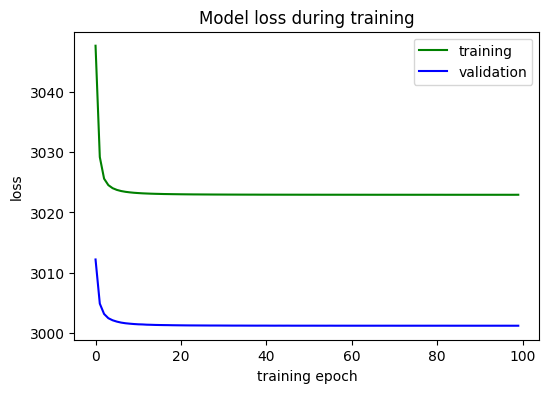

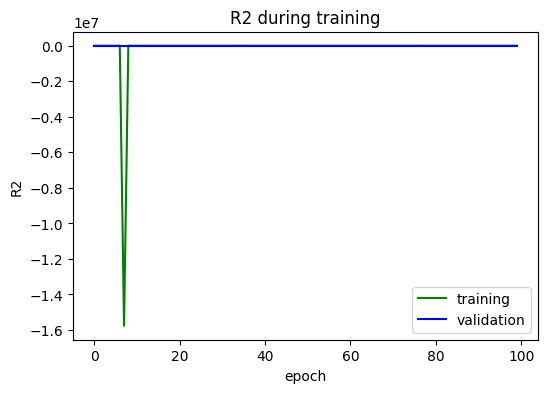

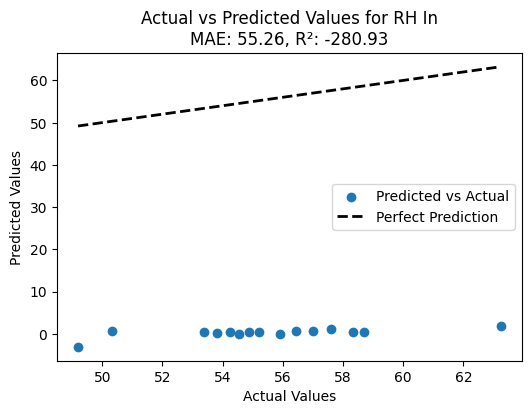

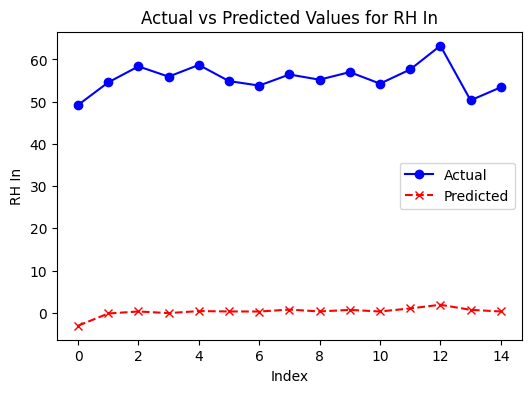

In [4]:
train_and_evaluate_gru_model('RH In', flag_train=True, _epochs=100, _batch_size=4)